In [1]:
import cv2 as cv
import numpy as np
import os
from keras_facenet import FaceNet
from sklearn.preprocessing import LabelEncoder
import pickle
import matplotlib.pyplot as plt
from ultralytics import YOLO

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
yolo_model = YOLO(r'C:\Projekty\PracaInz\Programs\runs\detect\train3\weights\best.pt')

In [8]:
facenet = FaceNet()
faces_embeddings = np.load(r'C:\Projekty\PracaInz\faces_embeddings_full_4.npz')
Y = faces_embeddings['arr_1']
encoder = LabelEncoder().fit(Y)
model = pickle.load(open(r'C:\Projekty\PracaInz\svm_model_160x160_4.pkl', 'rb'))

image_paths = [r'C:\Projekty\PracaInz\images_val\val_0.jpeg', 
               r'C:\Projekty\PracaInz\images_val\val_1.jpeg', 
               r'C:\Projekty\PracaInz\images_val\val_2.jpeg', 
               r'C:\Projekty\PracaInz\images_val\val_3.jpeg', 
               r'C:\Projekty\PracaInz\images_val\val_4.jpeg',
               r'C:\Projekty\PracaInz\images_val\val_5.jpeg',  
               r'C:\Projekty\PracaInz\images_val\val_6.jpeg']

0: 480x640 1 face, 80.7ms
Speed: 2.0ms preprocess, 80.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 2s 2s/step


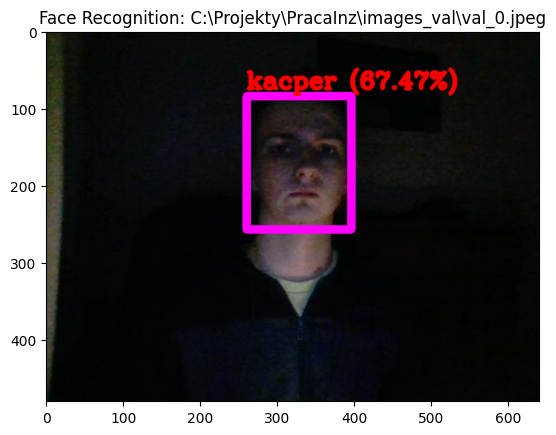


0: 480x640 1 face, 78.5ms
Speed: 3.5ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 65ms/step


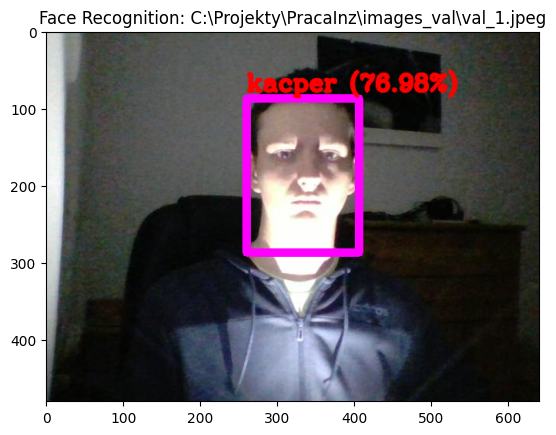


0: 480x640 1 face, 78.0ms
Speed: 4.6ms preprocess, 78.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 67ms/step


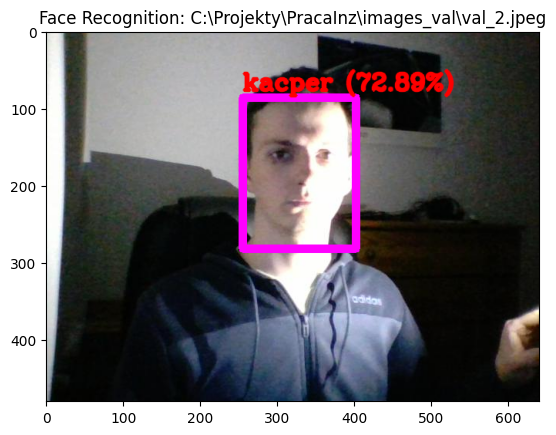


0: 480x640 1 face, 79.1ms
Speed: 3.6ms preprocess, 79.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 60ms/step


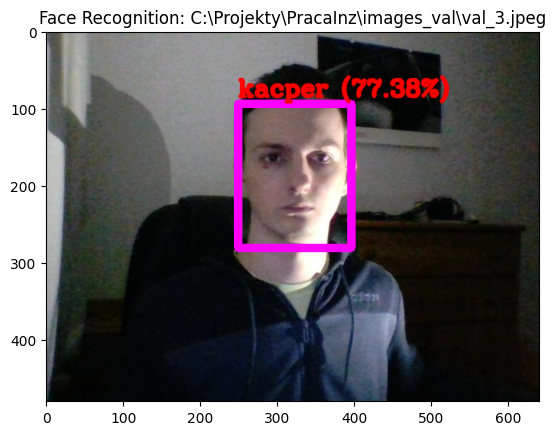


0: 480x640 1 face, 85.0ms
Speed: 0.0ms preprocess, 85.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 65ms/step


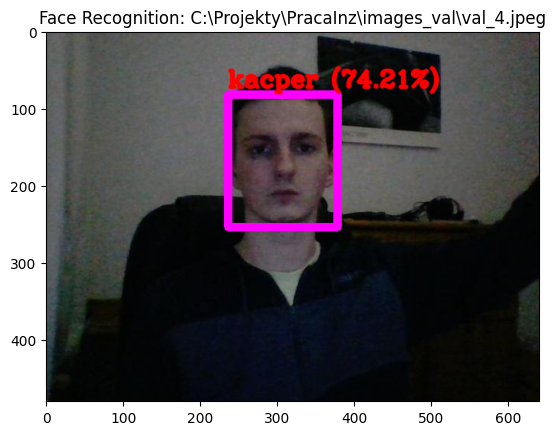


0: 480x640 1 face, 77.7ms
Speed: 4.0ms preprocess, 77.7ms inference, 0.0ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 62ms/step


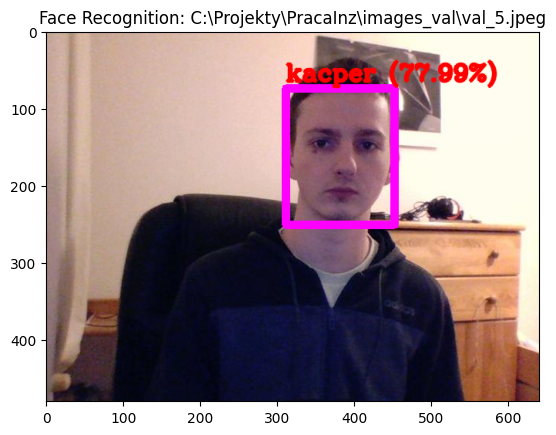


0: 480x640 1 face, 78.1ms
Speed: 4.2ms preprocess, 78.1ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)


1/1 [==============================] - 0s 60ms/step


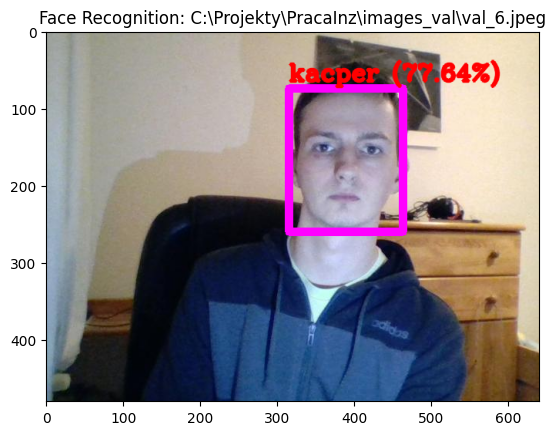

In [9]:
for image_path in image_paths:
    # Read the image
    frame = cv.imread(image_path)
    
    # YOLO prediction
    yolo_results = yolo_model.predict([image_path])

    for result in yolo_results:
        boxes = result.boxes
        for box in boxes:
            tlx = int(box.xyxy.tolist()[0][0])
            tly = int(box.xyxy.tolist()[0][1])
            brx = int(box.xyxy.tolist()[0][2])
            bry = int(box.xyxy.tolist()[0][3])

            # Crop and resize the face
            img = frame[tly:bry, tlx:brx]
            img = cv.resize(img, (160, 160))
            img = np.expand_dims(img, axis=0)

            # Get embeddings from FaceNet
            ypred = facenet.embeddings(img)

            # Predict using the SVM model
            face_name = model.predict(ypred)
            final_name = encoder.inverse_transform(face_name)[0]

            # Probability calculation
            yhat_prob = model.predict_proba(ypred)
            class_index = face_name[0]
            class_probability = yhat_prob[0, class_index] * 100
            predict_names = encoder.inverse_transform(face_name)

            final_name = predict_names[0]
            cv.rectangle(frame, (tlx, tly), (brx, bry), (255, 0, 255), 10)
            cv.putText(frame, f"{final_name} ({class_probability:.2f}%)", (tlx, tly - 10),
                    cv.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 3, cv.LINE_AA)

    # Display the result for each image
    plt.imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
    plt.title(f"Face Recognition: {image_path}")
    plt.show()
    save_path = os.path.join(r'C:\Projekty\PracaInz\results\full_4', f"face_recognition_{os.path.basename(image_path)}")
    plt.imsave(save_path, cv.cvtColor(frame, cv.COLOR_BGR2RGB))